# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

In [1]:
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import cv2

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


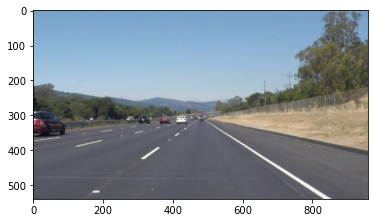

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines):

    # Calculate slopes and sizes of lanes
    lines = np.squeeze(lines)
    slopes = (lines[:,3]-lines[:,1]) / (lines[:,2] - lines[:,0])
    line_size = np.sqrt((lines[:,2] - lines[:,0])**2 + (lines[:,3]-lines[:,1])**2)

    # Get rid of outlier lines
    slope_threshold = 0.5
    lines = lines[np.abs(slopes)> slope_threshold]
    line_size = line_size[np.abs(slopes)> slope_threshold]
    slopes = slopes[np.abs(slopes)> slope_threshold]

    # Seperate positive and negative slopes, lines, and sizes
    left_slopes, right_slopes = slopes[slopes>0], slopes[slopes<0]
    left_lines, right_lines = lines[slopes>0,:], lines[slopes<0,:]
    left_lane_sizes, right_lane_sizes = line_size[slopes>0], line_size[slopes<0]

    # lanes sorted by size
    left_lane_sizes_sorted = np.argsort(left_lane_sizes)
    right_lane_sizes_sorted = np.argsort(right_lane_sizes)

    # Calculate average slope on the biggest 6 lines.
    left_slope_avg  = left_slopes[left_lane_sizes_sorted][-6::].mean()
    right_slope_avg = right_slopes[right_lane_sizes_sorted][-6::].mean()

    # find y intercept
    # b = y - m * x
    left_x_values, left_y_values = np.concatenate([left_lines[:,0], left_lines[:,2]]), np.concatenate([left_lines[:,1], left_lines[:,3]])
    right_x_values, right_y_values = np.concatenate([right_lines[:,0],right_lines[:,2]]), np.concatenate([right_lines[:,1], right_lines[:,3]])

    left_y_intercept = left_y_values - (left_slope_avg * left_x_values)
    right_y_intercept = right_y_values - (right_slope_avg * right_x_values)

    # find mean y-intercept based on n biggest lines
    left_y_intercept = left_y_intercept[left_lane_sizes_sorted][-6::]
    right_y_intercept = right_y_intercept[right_lane_sizes_sorted][-6::]
    left_y_intercept_avg, right_y_intercept_avg = np.mean(left_y_intercept), np.mean(right_y_intercept)

    imshape = img.shape
    img_floor = imshape[0]
    horizon_line = imshape[0]/1.5

    # calculate new points x = (y - b) / m

    # Right lane points
    max_right_x = (img_floor - right_y_intercept_avg) / right_slope_avg
    min_right_x = (horizon_line - right_y_intercept_avg) / right_slope_avg


    # Left lane points
    min_left_x = (img_floor - left_y_intercept_avg) / left_slope_avg
    max_left_x = (horizon_line - left_y_intercept_avg) / left_slope_avg


    l1 = (int(min_left_x), int(img_floor))
    l2 = (int(max_left_x), int(horizon_line))
    # print('Right points l1 and l2,', l1, l2)
    cv2.line(img, l1, l2, [0, 255, 0], 8)

    r1 = (int(max_right_x), int(img_floor))
    r2 = (int(min_right_x), int(horizon_line))
    # print('Left points l1 and l2,', l1, l2)
    cv2.line(img, r1, r2, [255, 0, 0], 8)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [5]:
def mark_lanes(image):
    if image is None: raise ValueError("no image given to mark_lanes")
    # grayscale the image to make finding gradients clearer
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges_img = cv2.Canny(np.uint8(blur_gray), low_threshold, high_threshold)


    imshape = image.shape
    vertices = np.array([[(0, imshape[0]),
                          (450, 320),
                          (490, 320),
                          (imshape[1], imshape[0]) ]],
                          dtype=np.int32)

    masked_edges = region_of_interest(edges_img, vertices )


    # Define the Hough transform parameters
    rho             = 2           # distance resolution in pixels of the Hough grid
    theta           = np.pi/180   # angular resolution in radians of the Hough grid
    threshold       = 5        # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10       # minimum number of pixels making up a line
    max_line_gap    = 20       # maximum gap in pixels between connectable line segments

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the image
    # initial_img * α + img * β + λ
    marked_lanes = cv2.addWeighted(image, 0.8, line_image, 1, 0)
    return marked_lanes

## Test on Images

**You might need to create the `marked` directory inside of test_images**


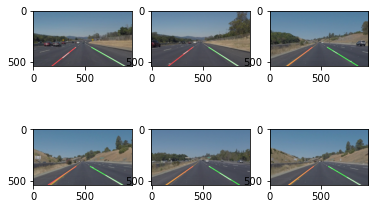

In [6]:
paths = glob.glob('test_images/*.jpg')

for i,image_path in enumerate(paths):
    image = mpimg.imread(image_path)
    result = mark_lanes(image)
    plt.subplot(2,3,i+1)
    plt.imshow(result)
    mpimg.imsave('test_images/marked/'+image_path[12:-4]+'_detected.jpg', result)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(mark_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video white.mp4.
Moviepy - Writing video white.mp4



Moviepy - Done !
Moviepy - video ready white.mp4
CPU times: total: 6.75 s
Wall time: 11.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(mark_lanes)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:  91%|█████████ | 618/681 [01:13<00:02, 21.44it/s, now=None]

Moviepy - Building video yellow.mp4.
Moviepy - Writing video yellow.mp4




t:  90%|█████████ | 616/681 [00:39<00:03, 17.57it/s, now=None]

ValueError: cannot convert float NaN to integer


t:  91%|█████████ | 618/681 [00:51<00:03, 17.57it/s, now=None]

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Reflections on Finding Lane Lines


This project was such a fantastic (and frustrating) learning experience. 

I spend a majority of my time at the beginning of the project looking through the forums to get ideas on how other students were approaching the problem as well as understanding how to use numpy and opencv. 

These are the three approaches I took towards drawing the lanes.



### Approach 1 - Extremum

The first approach was to simply collect all the points in the lane, find the topmost left and rightmost points and graph lines between them. This worked somewhat well but it lacked the ability to "fill in" where there was an absence of lane markings.

```python
    # Line Extremum Approach
    right_lines = np.array(list(filter(lambda x: x[0] > (img.shape[1]/2), lines)))
    max_right_x, max_right_y = right_lines.max(axis=0)
    min_right_x, min_right_y = right_lines.min(axis=0)
```



### Approach 2 - Average Slope 

Another, more robust way that should work theorhetically would be to predict the x coordinates based on the average slope and solving for it with the average slope and average y and y intercept.

```python
    # Average slope Approach
    avg_right_slope = right_slopes.mean()

    # average point
    avg_right_point = np.mean(right_lines, axis=0)

    # y intercept of right line
    # b = y - mx
    right_y_intercept = avg_right_point[1] - avg_right_slope * avg_right_point[0]

    # Calculate x values based on average slope and y intercept
    max_right_x = int((min_right_y - right_y_intercept)/avg_right_slope)
    min_right_x = int((max_right_y - right_y_intercept)/avg_right_slope)
    
    r1 = (min_right_x, min_right_y)
    r2 = (max_right_x, img.shape[0]) # ground to bottom of image
```

This however would get thrown off by outliers returned by the Hough transform. 


### Approach 3 - Curve fitting

This felt like the most robust way to connect the dots by using numpy to generate a polynomial curve that modeled each lane, and the one that I'm using in my submission. I'm definitely the most happy with the results for this one becuase it allows us to generate sensible x values to complete the lanes when there are dashed lines in the road.

```python
    # Curve fitting approach
    # calculate polynomial fit for the points in right lane
    right_curve = np.poly1d(np.polyfit(right_lines[:,1], right_lines[:,0], 2))
    left_curve  = np.poly1d(np.polyfit(left_lines[:,1], left_lines[:,0], 2))

    # use new curve function f(y) to calculate x values
    max_right_x = int(right_curve(img.shape[0]))
    min_left_x = int(left_curve(img.shape[0]))
```



### Approach 4 - Return of the ~~Sith~~ 2nd Approach

After getting feedback from the instructors on the first submission that used curve fitting as the final approach, I was told to try improving the second approach again, calculating average slope, but I needed to remove outliers. 

It seems that only considering some of the maximum line lengths and averaging those got us much better results when taking our averages, but the noise can still be seen on a couple of rogue frames. 


## How could this algorithm be improved? 


I think we're making an assumption about the "horizon line" such that we can use a triangle to generalize about what most roads are going to look like. Curved sections, for example will give us problems since we're only drawing single lines between points. 

More importantly we currently look for gradients that are rather large in order to find the color changes in the road.
This won't be very well suited for dirt roads and lanes who's markings have faded and will have less contrast. Low light conditions will also reduce the contrast in the images we take. 

There also is something to be said about removing outliers from the points given to us be the hough transformation.
For example we could get noise from cars and other lanes (including double lanes or stripes in unique areas).

To get rid of the outliers, something like the median gives us a much better sense of where most of the values in a set lie, so we could look in both directions from the median in order to filter out extra points.

```
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]
```


One last thing thought is that we currently consider the video a set of disjoint frames, resulting in lines that are all drawn independently of each other but we could potentially smooth the lines over sets of frames to prevent the frames from looking too different from each other. 

If I had more time I would certainly want to look into these options as well as try to trim any `NaN` errors returned from the edge detectoon. (**This is certainly a problem within  the challenge video!**) I appreciated the opportunity to learn and work with Numpy and openCV. It was a fantastic set of tools to work with and I'm really happy to have built a moderately successful result. 

Thank you to the mentors as well as the office hour instructors.

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(mark_lanes)
%time challenge_clip.write_videofile(challenge_output, audio=False)


                                                              
t:  91%|█████████ | 618/681 [03:18<00:02, 21.44it/s, now=None]
                                                              
t:  91%|█████████ | 618/681 [03:18<00:02, 21.44it/s, now=None]

Moviepy - Building video extra.mp4.
Moviepy - Writing video extra.mp4





t:   0%|          | 0/251 [00:00<?, ?it/s, now=None]

t:   1%|          | 2/251 [00:00<00:22, 10.93it/s, now=None]

t:   2%|▏         | 4/251 [00:00<00:18, 13.47it/s, now=None]

t:   2%|▏         | 6/251 [00:00<00:16, 15.07it/s, now=None]

t:   3%|▎         | 8/251 [00:00<00:15, 15.89it/s, now=None]

ValueError: cannot convert float NaN to integer



t:   4%|▎         | 9/251 [00:17<00:15, 15.89it/s, now=None]

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))